**Importing packages that we need**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, vectorize

**Setting up the Monte Carlo method for a NxN lattice:**

In [3]:
#function that defines that inital state for the lattice calling a random number generator
@jit()
def StateInitalize(N):
    #NXN number of spins
    Lattice = np.zeros((N,N))
    for i in range(N):
        for l in range(N):
            randNum = np.random.random()
            if randNum < 0.5:
                Lattice[i,l] = int(-1)
            else:
                Lattice[i,l] = int(1)
                
    return Lattice

**NeigbourInteraction is a function that calculates the change in energy upon flipping one spin:**

In [7]:
@jit()
def NeigbourInteraction(line,column,InitialState,LatticeSize):
    M = LatticeSize
    DeltaE = 0
    if line == int(0):#if at the top edge of lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line+1,column]#below
    if line == int((M-1)):#if at the bottom edge lattice
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line-1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below
    #Then check if at left or right edges or inside
    else:
        #State to the left
        if column == int(0):
            Temp1 = InitialState[line,column]*InitialState[line,column+1]#to the left
        else:
            Temp1 = InitialState[line,column]*InitialState[line,column-1]#to the left
        #State to the right
        if column == int((M-1)):
            Temp2 = InitialState[line,column]*InitialState[line,column-1]#to the right
        else:
            Temp2 = InitialState[line,column]*InitialState[line,column+1]#to the right
        #State above
        Temp3 = InitialState[line,column]*InitialState[line+1,column]#above
        #State below
        Temp4 = InitialState[line,column]*InitialState[line-1,column]#below

    DeltaE = -(Temp1 + Temp2 + Temp3 + Temp4)
    DeltaE = DeltaE*2
    #print("DeltaE is:",DeltaE)
    return DeltaE

**Calculating the energy of the lattice according to the Ising model with periodic boundary conditions:**

In [8]:
def LatticeEnergyIsing(InitialState,LatticeSize):
    #M = LatticeSize
    N,M = np.shape(InitialState)
    Energy = 0
    #print("Inital Energy:",Energy)
    for i in range(M):#loop over lines
        for j in range(M):#loop over columns
            Acceptance = (np.mod(i,2)+np.mod(j,2) == 0) or (np.mod(i,2)+np.mod(j,2) == 2)
            #print(Acceptance)
            if Acceptance:
                if (i == 0 and j == 0):#if at the top and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == 0 and j == (M-1)):#if at the top and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == 0):#if at the bottom and left edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif (i == (M-1) and j == (M-1)):#if at the bottom and right edge of lattice
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == 0:#if only at top edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i+1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif i == (M-1):#if only at bottom edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i-1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == 0:#if only at left edge
                    Temp1 = InitialState[i,j]*InitialState[i,j+1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                elif j == (M-1):#if only at right edge
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j-1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                else:#if somewhere in the middle
                    Temp1 = InitialState[i,j]*InitialState[i,j-1]#to the right
                    Temp2 = InitialState[i,j]*InitialState[i,j+1]#to the left
                    Temp3 = InitialState[i,j]*InitialState[i-1,j]#above
                    Temp4 = InitialState[i,j]*InitialState[i+1,j]#below
                    Energy += - (Temp1 + Temp2 + Temp3 + Temp4)
                
    return Energy

In [10]:
#Trial of energy
B = np.array([[1,1],[1,1]])
print(B)
EnergyTrial = LatticeEnergyIsing(B,2)
print("The energy according to Ising Model:", EnergyTrial)

[[1 1]
 [1 1]]
The energy according to Ising Model: -8


**Metropolis part:**

In [11]:
def Metropolis(DeltaEnergy,Temperature):
    Accept = False
    Exp1 = np.exp(-(1/Temperature)*(-8))
    Exp2 = np.exp(-(1/Temperature)*(-4))
    Exp3 = 1
    Exp4 = np.exp(-(1/Temperature)*(4))
    Exp5 = np.exp(-(1/Temperature)*(8))
    if DeltaEnergy < 0:
        Accept = True
    else:
        randNum = np.random.random()
        if DeltaEnergy == -8:
            w = Exp1
        elif DeltaEnergy == -4:
            w = Exp2
        elif DeltaEnergy == 0:
            w = Exp3
        elif DeltaEnergy == 4:
            w = Exp4
        else:
            w = Exp5
        #Checking w agains the exponent and accepting if r <= w
        if randNum <= w:
            Accept = True
        else:
            Accept = False
            
    return Accept

**The Monte Carlo calculation itself:**

In [43]:
def MonteCarloIsing(InitialState1,NumOfCycles,LatticeSize,Temperature):
    EnergyVector = []
    T = Temperature
    M = LatticeSize
    print(InitialState1)
    EnergyMatrix = InitialState1
    InitialState = InitialState1#Setting a lattice for overwriting
    #Calculating the initial energy
    Energy = LatticeEnergyIsing(EnergyMatrix,M)
    #print(Energy)
    MC = NumOfCycles
    CounterAcceptance = 0#Counter to see how many moves are accepted
    for i in range(MC):#Looping over the number of MC cycles
        #picking a random coordinate in the lattice
        randNum = np.random.randint(M*M)
        line = int(np.floor(randNum/M))#finding the relavant line in the lattice
        column = int(randNum - M*line)#finding the relavant column in the lattice
        #print(randNum,line,column)
        #flipping the spin at that position
        TempState = InitialState.copy()
        #print(InitialState[line,column])
        #print(InitialState)
        if InitialState[line,column] == 1:
            TempState[line,column] = int(-1)
            tempValue = int(-1)#setting temp value to the assign to the system if move is accepted
            #print("obs",line,column)
            #print("State where spin flipped:")
            #print(TempState)
            #print("Initial State:")
            #print(InitialState)#Inital state er af einhverju ástæðum að breytast eins og temp state!!!
        else:
            TempState[line,column] = int(1)
            tempValue = int(1)#setting temp value to the assign to the system if move is accepted
        #finding the difference in energy - using periodic boundary conditions
        DeltaE = NeigbourInteraction(line,column,TempState,M)
        Acceptance = Metropolis(DeltaE,T)
        #print(Acceptance)
        #print(DeltaE)
        #Metropolis part
        if Acceptance:
            InitialState[line,column] = tempValue
            CounterAcceptance += 1   
        Energy = LatticeEnergyIsing(InitialState,M)#Þarf að taka alltaf gildin á orkunni!!!
        #print(Energy)
        EnergyVector.append(Energy)
        #End of MC loop
        
    #print(InitialState)
    #print(Energy)
    FinalEnergy = LatticeEnergyIsing(InitialState,M)
    #Calculating average energy per particle
    TotalEnergy = sum(EnergyVector)
    #print(TotalEnergy)
    AverageEnergy = TotalEnergy/MC
    EnergyPerParticle = AverageEnergy/(M*M)

    return FinalEnergy, CounterAcceptance, EnergyVector, EnergyPerParticle

**Trying the algo:**

In [49]:
A = StateInitalize(2)
EnergyMC, AcceptedMoves, EnergyAll, EnergyPerPart = MonteCarloIsing(A,1000,2,1)
print(EnergyMC)
print(AcceptedMoves)
print(EnergyPerPart)

[[-1. -1.]
 [-1.  1.]]
-8.0
15
-1.966


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


ValueError: x and y must have same first dimension, but have shapes (15,) and (1000,)

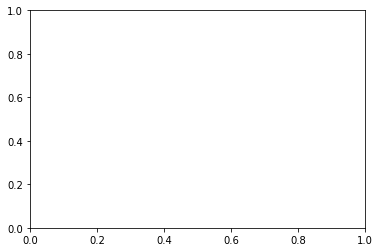

In [50]:
fig, ax = plt.subplots()
Steps = np.arange(0,AcceptedMoves)
print(Steps)
ax.plot(Steps,EnergyAll,'*')

**NEED TO ADRESS THE FACT THAT I AM COUNTING TWICE!!**

In [14]:
print(int(-1))
C = np.array([[1,1],[-1,1]])
print(C)
C[0,0] = int(-1)
print(C)

-1
[[ 1  1]
 [-1  1]]
[[-1  1]
 [-1  1]]
